
# Semantic Phasor Demo

This notebook shows an interesting property of phasors when applied to textual data. We hope this will convince readers that this is a promising approach to creating vector representations of documents.

## What the heck is a phasor? 

A phasor is just a complex number, but it has an interpretation built in: it represents *both* the amplitude and the phase of a sine wave of a fixed frequency. That is, it represents both how tall the wave is, and also where the wave starts (in the middle, up high, or down low).

The output of a Fourier transform for a particular frequency is the same thing as a phasor. So in a sense "doing stuff with phasors" is just another way of saying "Fourier analysis." But we talk about them here as phasors because it emphasizes this:

### Phasors can be added and subtracted just like vectors. 

When you add two phasors for a given frequency together, you get a new phasor. It represents a wave with the same frequency, but with a different amplitude, and a different phase offset. There's a nice way of visualizing the geometry of this operation -- this is from the Wikipedia article on [phasors](https://en.wikipedia.org/wiki/Phasor): 

<img src="Sumafasores.gif" alt="An image showing the geometry of phasor addition." width="200px" />

The purple phasor is the sum of the red and blue phasors. Adding together wave signals seems a bit complicated, but the underlying geometry is the same as ordinary vector addition. It's just that the vectors are also rotating at a fixed rate around the origin.

Because you can add and subtract phasors just like vectors, you can combine them with other vector-like objects -- including word embedding vectors. As long as the Fourier transform is run over dimensions that are orthogonal to one another, the resulting vectors are composable in the same way as word embeddings.

## What does this notebook do with phasors?

We wanted to see if there are any obvious patterns that phasors preserve. So we decided to see what happens when you "rotate" a text.

Suppose you sliced off the first few hundred words of a text, tacked them on at the end, and then repeated that process until you were back where you began. It's as if you laid the words of the text out on a big wheel and started spinning it. Early rotations would start near the beginning of the original story, and end near the beginning again. Middle rotations would start in the middle of the original story, and end in the middle again. The very last one would be identical to the original.

This notebook shows what happens if you take those rotated texts and do the following:

1. Convert them into word vectors.
2. Perform Fourier transforms over each dimension, and converting the resulting phasors into ordinary vectors, which represent whole documents.
3. Pass the resulting document vectors to a UMAP model, which tries to preserve the topology of its input in a lower dimension.

What will it look like? Let's see!

In [21]:
import itertools

import spacy
import numpy
import umap
import matplotlib.pyplot as plt
%matplotlib inline

en = spacy.load('en_core_web_md')

After a few imports, we load two files -- Frankenstein and Hamlet, both from Project Gutenberg -- and parse them using `spacy`. We use `spacy` because it provides pre-trained word vectors.

In [22]:
with open('frank.txt') as ip:
    frank = ip.read()
with open('ham.txt') as ip:
    ham = ip.read()

In [33]:
frank_sp = en(frank)
ham_sp = en(ham)

Here are some utility functions. 

- `text_vecs` takes the parsed text and generates the vectors, optionally rotating them by the number of words given by `offset`. 
- `group_sum` chunks the text up and sums the chunks, which makes the Fourier transform faster without losing too much accuracy. (Ideally, we'd like to do the transform over the raw data, but that takes a lot of time.)
- `fft_vecs` takes the vectors for a text, performs the Fourier transform, and packages the result into one long vector.

In [34]:
def text_vecs(text_sp, offset=0):
    a = text_sp[offset:]
    b = text_sp[:offset]
    return numpy.array([t.vector.reshape(-1) for part in [a, b]
                                             for t in part])

def group_sum(vec, n_groups):
    size = len(vec) / n_groups
    ends = []
    for i in range(1, n_groups + 1):
        ends.append(int(size * i))
    ends[-1] = len(vec)
    
    sums = []
    start = 0
    for e in ends:
        sums.append(vec[start:e].sum())
        start = e
        
    return numpy.array(sums)
        
def fft_vecs(vecs, n_bands=10):
    fft_cols = []
    n_groups = 1
    while n_groups < n_bands * 4:
        n_groups *= 2
        
    for col in range(vecs.shape[1]):
        vec = vecs[:, col]
        vec = group_sum(vec, n_groups)
        fft = numpy.fft.rfft(vec)
        fft_cols.append(fft[:n_bands])
    return numpy.array(fft_cols).reshape(-1)

Here's a quick check to make sure the first function isn't doing something obviously wrong.

In [35]:
frank_vecs = numpy.array([t.vector.reshape(-1) for t in frank_sp])
assert (text_vecs(frank_sp, 0) == frank_vecs).all()

## Step 1

Now we generate the rotated word vectors. These are lists of matrices with 300 columns and VERYMANY rows, where VERYMANY is the number of words in the text. We're doing it in a slow way, so it takes a little while.

In [36]:
frank_rotations = (text_vecs(frank_sp, offset) for offset in range(0, len(frank_sp), (len(frank_sp) // 100) + 1))
ham_rotations = (text_vecs(ham_sp, offset) for offset in range(0, len(ham_sp), (len(ham_sp) // 100) + 1)) 
rotations = itertools.chain(frank_rotations, ham_rotations)

## Step 2

Now we do the fourier transforms. This also takes a little while.

In [37]:
rot_vecs_fft = [fft_vecs(r) for r in rotations]

We want to hold on to a copy of the original fourier transform data just in case, so we give it a new name for manipulation. If we ever want to reset anything below without having to re-do the fourier transforms, we can just run the below cell again.

In [38]:
rot_vecs = rot_vecs_fft

Now we unpack the fourier transformed data into regular vectors. This means decomposing the complex numbers into pairs of regular floating point numbers. For our purposes, this is fine, because we aren't doing any multiplication. 

In [39]:

rot_vecs = [[(x.real, x.imag) for x in arr] for arr in rot_vecs]
rot_vecs = [[k for i_j in arr for k in i_j] for arr in rot_vecs]
rot_vec_array = numpy.array(rot_vecs)
rot_vec_array.shape

(200, 6000)

## Step 3

Finally, we pass the resulting document vectors to UMAP. To review, right now, we have 200 vectors of 6000 dimensions each. Each vector represents one document, and each document is a version of either *Frankenstein* or *Hamlet* rotated by some number of words.

We want to see how `UMAP` lays out these vectors. Without getting into details, UMAP is a very useful algorithem that takes points in a high-dimensional space and tries to preserve the topology of those points in a low-dimensional space. This is different from more familiar alogirthms like t-SNE, which only try to preserve distance; UMAP actually assumes that the input data has an overall shape, and does its best to reproduce that same shape in a lower dimension.

What shape will we see?

In [40]:
um = umap.UMAP(n_neighbors=5)

In [41]:
vis = um.fit_transform(rot_vec_array)

/home/dcuser/.virtualenvs/test/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


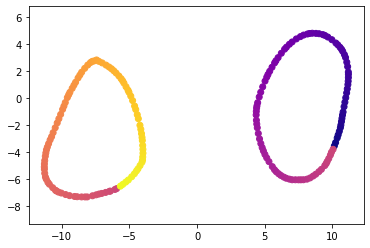

In [42]:
plt.gca().axis('equal')
plt.scatter(vis[:, 0], 
            vis[:, 1], 
            c=[i / len(vis) for i in range(len(vis))],
            cmap='plasma')

UMAP has done a great job of recreating the topology of the original data. The data was generated by rotation, and so it has given us circles!

This doesn't prove that phasors will solve any real-world problems. But it does show that they do a good job of preserving certain information about the relative position of semantic peaks and troughs in documents. And it strongly suggests that they will help find duplicate documents without being overly sensitive to front- and end-matter. Since the overall peaks and troughs of two duplicates will be the same, any differences in offset will show up as small displacements around a circle.